# FODS Assignment 1

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [45]:
df = pd.read_csv("./data.csv")

In [46]:
df.head()

,X,Y
0,0.987988,5.098368
1,0.719720,2.516654
2,-0.403403,0.337961
3,0.107107,0.737320
4,0.345345,-0.780955


## TASK 1

In [47]:
mean_y = df['Y'].mean()
std_y = df['Y'].std()

### Normalizing 

In [48]:
df['Y'] = (df['Y'] - mean_y) / std_y

In [49]:
df.tail()

,X,Y
995,0.671672,1.174380
996,-0.615616,-0.512541
997,0.259259,0.062779
998,0.119119,-0.392207
999,0.369369,-0.226423


In [50]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_set, test_set = df[:800], df[800:]

In [51]:
print("Training Set:")
print(train_set)
print("\nTesting Set:")
print(test_set)

Training Set:
            X         Y
0   -0.851852 -1.119315
1   -0.853854 -2.033919
2    0.159159  0.660240
3   -0.617618 -0.348264
4   -0.219219  0.315293
..        ...       ...
795 -0.125125  0.023610
796  0.479479 -0.277378
797  0.243243 -0.154319
798 -0.437437  0.403846
799 -0.927928 -1.061514

[800 rows x 2 columns]

Testing Set:
            X         Y
800  0.673674  0.232092
801  0.595596 -0.103215
802  0.485485  1.248083
803 -0.765766 -1.053501
804  0.387387 -0.829054
..        ...       ...
995  0.333333  0.093957
996  0.423423  0.568719
997 -0.803804 -1.053091
998 -0.551552 -1.197638
999 -0.869870 -1.652367

[200 rows x 2 columns]


### Visualizing

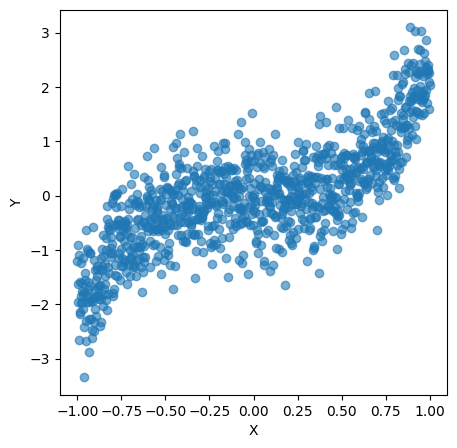

In [52]:
plt.figure(figsize=(5, 5))
scatter = plt.scatter(df['X'], df['Y'], alpha = 0.6)

plt.xlabel('X')
plt.ylabel('Y')

plt.show()

## Task 2

#### Pre-compute helper function for calulating the polynomial values for all the X values

In [53]:
def pre_compute(X, deg):
    return np.array([X ** i for i in range(deg + 1)]).T

In [54]:
def compute_error(poly_matrix, Y, w):
    error = 0
    for i in range(len(Y)):
        error += (np.dot(poly_matrix[i], w) - Y[i]) ** 2    
    return error / 2


In [55]:
def gradient(poly_matrix, Y, w):

    err = (np.dot(poly_matrix, w)) - Y
    slope = np.dot(poly_matrix.T, err)
    return slope

In [56]:
def gradient_descent(poly_matrix, Y, w, start, end):
    
    w_old = w.copy()
    w -= 0.0001 * gradient(poly_matrix[start:end], Y[start:end], w_old)

    return w

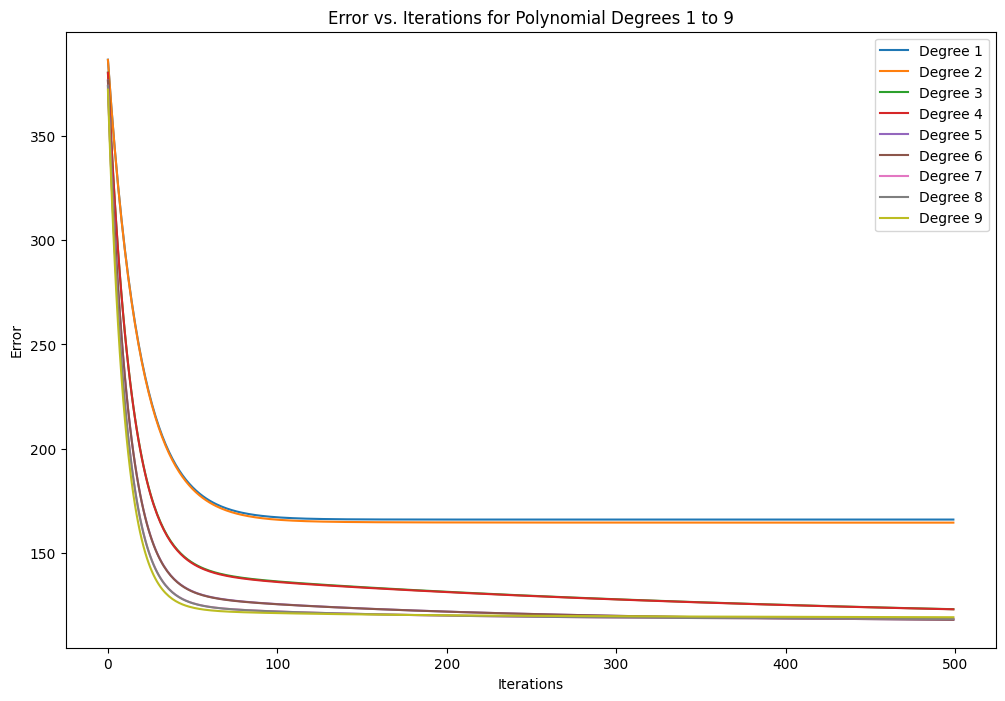

In [57]:
all_errors = {}
batches = 4
multiple = 200

for deg in range(1, 10):
    errors = []
    w = np.zeros(deg + 1)
    polynomial = pre_compute(train_set['X'], deg)

    for itr in range(500):

        # For each batch
        for batch in range(batches):

            w = gradient_descent(
                polynomial,
                train_set['Y'],
                w,
                batch * multiple,
                (batch + 1) * multiple - 1
            )

        error = compute_error(polynomial, train_set['Y'], w)
        errors.append(error)

    all_errors[deg] = errors

plt.figure(figsize=(12, 8))
for deg, errors in all_errors.items():
    plt.plot(errors, label=f"Degree {deg}")

plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title("Error vs. Iterations for Polynomial Degrees 1 to 9")
plt.legend()
plt.show()

In [58]:
def compute_error_l2(poly_matrix, Y, w, lmdba):
    error = 0
    for i in range(len(Y)):
        error += (np.dot(poly_matrix[i], w) - Y[i]) ** 2    
    return error / 2


In [59]:

def gradient_l2(poly_matrix, Y, w, lmbda):

    err = (np.dot(poly_matrix, w)) - Y
    slope = np.dot(poly_matrix.T, err)
    return slope


In [60]:

def gradient_descent_l2(poly_matrix, Y, w, start, end, lmbda):
    
    w_old = w.copy()
    w -= 0.0001 * gradient(poly_matrix[start:end], Y[start:end], w_old)

    return w


In [61]:
all_bias = {}
all_variance = {}
all_total_error = {}
batches = 4
multiple = 200

lambdas = np.linspace(0, 1, 100)

for deg in range(1, 10):
    errors = []
    w = np.zeros(deg + 1)
    polynomial = pre_compute(train_set['X'], deg)

    for l2_lambda in lambdas:

        for itr in range(500):
            # For each batch
            for batch in range(batches):

                w = gradient_descent_l2(
                    polynomial,
                    train_set['Y'],
                    w,
                    batch * multiple,
                    (batch + 1) * multiple - 1,
                    l2_lambda
                )

            error = compute_error(polynomial, train_set['Y'], w, deg)
            errors.append(error)

    all_errors[deg] = errors

plt.figure(figsize=(12, 8))
for deg, errors in all_errors.items():
    plt.plot(errors, label=f"Degree {deg}")

plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title("Error vs. Iterations for Polynomial Degrees 1 to 9")
plt.legend()
plt.show()